<a href="https://colab.research.google.com/github/aysenurrakcan/HackBio-StageThree/blob/main/stage_three_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scanpy anndata numpy


In [ ]:

import scanpy as sc
import anndata as ad
import numpy as np

# veri okuma (senin Colab yolların)
mock_adata = sc.read_10x_mtx('/content/mock/')
day_one   = sc.read_10x_mtx('/content/1dpi/')
day_two   = sc.read_10x_mtx('/content/2dpi/')
day_three = sc.read_10x_mtx('/content/3dpi/')

mock_adata.obs['condition'] = 'mock'
day_one.obs['condition'] = 'one'
day_two.obs['condition'] = 'two'
day_three.obs['condition'] = 'three'

print(mock_adata)
print(day_one)
print(day_two)
print(day_three)

AnnData object with n_obs × n_vars = 22609 × 33539
    obs: 'condition'
    var: 'gene_ids', 'feature_types'
AnnData object with n_obs × n_vars = 11834 × 33539
    obs: 'condition'
    var: 'gene_ids', 'feature_types'
AnnData object with n_obs × n_vars = 14695 × 33539
    obs: 'condition'
    var: 'gene_ids', 'feature_types'
AnnData object with n_obs × n_vars = 28530 × 33539
    obs: 'condition'
    var: 'gene_ids', 'feature_types'


In [ ]:
import scanpy as sc

# adataları daha önce yüklediysen varsayalım: mock_adata, day_one, day_two, day_three
adatas = [mock_adata, day_one, day_two, day_three]
for ad, name in zip(adatas, ['mock','one','two','three']):
    ad.obs['sample'] = name

# concatenate (hocanın pipeline'ına uygun)
adata = adatas[0].concatenate(adatas[1:], batch_key='batch', batch_categories=['mock','one','two','three'], index_unique=None)

# mt genlerini işaretle (var_names büyük-küçük hassas olabilir)
adata.var['mt'] = adata.var_names.str.upper().str.startswith('MT-')

# QC metrikleri
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

# Hızlı tablo özetini yazdır
print("Concatenated AnnData:", adata)
print(adata.obs.groupby('sample')[['n_genes_by_counts','total_counts','pct_counts_mt']].median())

/tmp/ipython-input-3454315879.py:9: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adatas[0].concatenate(adatas[1:], batch_key='batch', batch_categories=['mock','one','two','three'], index_unique=None)
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1796: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1796: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Concatenated AnnData: AnnData object with n_obs × n_vars = 77668 × 33539
    obs: 'condition', 'sample', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
        n_genes_by_counts  total_counts  pct_counts_mt
sample                                                
mock               2233.0        6900.0       4.092023
one                3620.5       11998.0       7.059559
three              2129.0        5572.5       8.657486
two                3368.0       10857.0       7.127603


In [ ]:
# QC filtering (hocanın pipeline kodu)
sc.pp.filter_cells(adata, min_counts=500)
sc.pp.filter_genes(adata, min_cells=30)

adata = adata[adata.obs.pct_counts_mt < 20, :]   # mitochondrial filter
adata = adata[adata.obs.n_genes_by_counts < 8000, :]
adata = adata[adata.obs.n_genes_by_counts > 300, :]

print(adata)


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1796: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


View of AnnData object with n_obs × n_vars = 75313 × 20131
    obs: 'condition', 'sample', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1796: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
adata.obs_names_make_unique()  # önerilir: aynı obs isimlerini benzersiz yapar


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1796: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
!pip install --quiet scikit-misc


In [ ]:
!pip install python-igraph


/usr/local/lib/python3.12/dist-packages/legacy_api_wrap/__init__.py:88: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)
/tmp/ipython-input-3221175282.py:22: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added='leiden_r0.6', resolution=0.6)


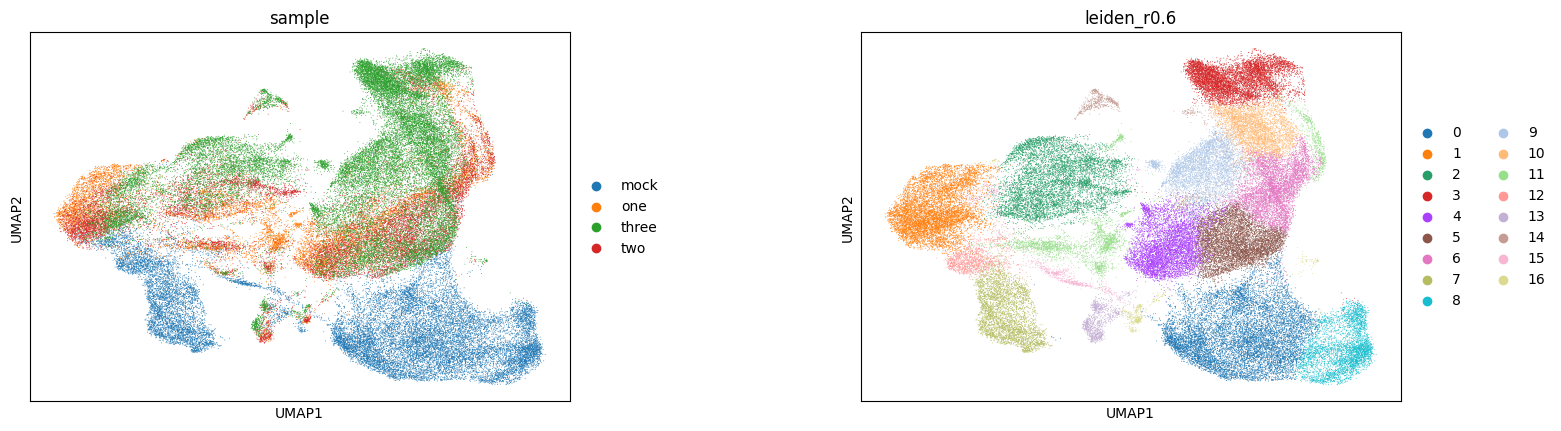

Kaydetme işlemi başlıyor...
Saved: /content/merged_sarscov2_postQC.h5ad


In [ ]:
import scanpy as sc

!pip install leidenalg

# (İstersen yorum satırı yap: # adata.obs_names_make_unique()  )
adata.obs_names_make_unique()  # önerilir: aynı obs isimlerini benzersiz yapar

# Normalize + log
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# HVG seç (hocanın kullandığı ayar)
sc.pp.highly_variable_genes(adata, n_top_genes=1500, subset=True, flavor='seurat_v3')

# Scale + PCA
#sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

# neighbors + UMAP + Leiden clustering
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=25)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added='leiden_r0.6', resolution=0.6)

# Görselleştirme
sc.pl.umap(adata, color=['sample','leiden_r0.6'], wspace=0.4, show=True)


# Kaydet
print("Kaydetme işlemi başlıyor...")
adata.write('/content/merged_sarscov2_postQC.h5ad')
print("Saved: /content/merged_sarscov2_postQC.h5ad")

In [ ]:
mock_adata.var.head()
day_one.var.head()
day_two.var.head()
day_three.var.head()

,gene_ids,feature_types
MIR1302-2HG,ENSG00000243485,Gene Expression
FAM138A,ENSG00000237613,Gene Expression
OR4F5,ENSG00000186092,Gene Expression
AL627309.1,ENSG00000238009,Gene Expression
AL627309.3,ENSG00000239945,Gene Expression


In [ ]:
#mock
mock_adata.var['MT'] = mock_adata.var_names.str.startswith(("MT-"))
mock_adata.var['RIBO'] = mock_adata.var_names.str.startswith(("RPS", "RPL"))
mock_adata.var['HB'] = mock_adata.var_names.str.startswith(("^HB[^(P)]"))

#day 1
day_one.var['MT'] = day_one.var_names.str.startswith(("MT-"))
day_one.var['RIBO'] = day_one.var_names.str.startswith(("RPS", "RPL"))
day_one.var['HB'] = day_one.var_names.str.startswith(("^HB[^(P)]"))

#day 2
day_two.var['MT'] = day_two.var_names.str.startswith(("MT-"))
day_two.var['RIBO'] = day_two.var_names.str.startswith(("RPS", "RPL"))
day_two.var['HB'] = day_two.var_names.str.startswith(("^HB[^(P)]"))

#day 3
day_three.var['MT'] = day_three.var_names.str.startswith(("MT-"))
day_three.var['RIBO'] = day_three.var_names.str.startswith(("RPS", "RPL"))
day_three.var['HB'] = day_three.var_names.str.startswith(("^HB[^(P)]"))

In [ ]:
#mock
sc.pp.calculate_qc_metrics(
    mock_adata, qc_vars=["MT", 'RIBO', 'HB'], inplace=True, log1p=True
)

#day 1
sc.pp.calculate_qc_metrics(
    day_one, qc_vars=["MT", 'RIBO', 'HB'], inplace=True, log1p=True
)

#day 2
sc.pp.calculate_qc_metrics(
    day_two, qc_vars=["MT", 'RIBO', 'HB'], inplace=True, log1p=True
)

#day 3
sc.pp.calculate_qc_metrics(
    day_three, qc_vars=["MT", 'RIBO', 'HB'], inplace=True, log1p=True
)

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (3,2)  # Adjust figure size
plt.rcParams["axes.grid"] = True  # Add grid to plots
plt.rcParams["axes.edgecolor"] = "black" # Set plot border color
plt.rcParams["axes.linewidth"] = 1.5 # Set plot border width
plt.rcParams["axes.facecolor"] = "white" # Set background color
plt.rcParams["axes.labelcolor"] = "black" # Set label color
plt.rcParams["xtick.color"] = "black" # Set x-axis tick color
plt.rcParams["ytick.color"] = "black" # Set y-axis tick color
plt.rcParams["text.color"] = "black" # Set text color
%matplotlib inline

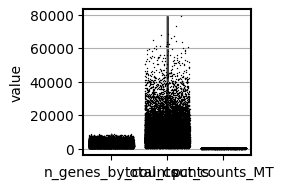

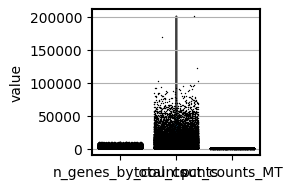

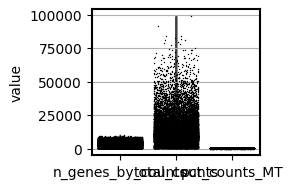

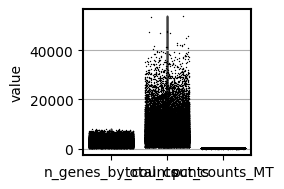

In [ ]:
import scanpy as sc

#mock
sc.pl.violin(
    mock_adata,
    ["n_genes_by_counts", 'total_counts', 'pct_counts_MT'],
    jitter=0.4,
    multi_panel=False,
)

#day 1
sc.pl.violin(
    day_one,
    ["n_genes_by_counts", 'total_counts', 'pct_counts_MT'],
    jitter=0.4,
    multi_panel=False,
)

#day 2
sc.pl.violin(
    day_two,
    ["n_genes_by_counts", 'total_counts', 'pct_counts_MT'],
    jitter=0.4,
    multi_panel=False,
)


#day 3
sc.pl.violin(
    day_three,
    ["n_genes_by_counts", 'total_counts', 'pct_counts_MT'],
    jitter=0.4,
    multi_panel=False,
)

In [ ]:
#Normalisation

#mock
mock_adata.layers["counts"] = mock_adata.X.copy()
sc.pp.normalize_total(mock_adata)
sc.pp.log1p(mock_adata)

#mock
day_one.layers["counts"] = day_one.X.copy()
sc.pp.normalize_total(day_one)
sc.pp.log1p(day_one)

#mock
day_two.layers["counts"] = day_two.X.copy()
sc.pp.normalize_total(day_two)
sc.pp.log1p(day_two)

#mock
day_three.layers["counts"] = day_three.X.copy()
sc.pp.normalize_total(day_three)
sc.pp.log1p(day_three)

In [ ]:
#Feature selection
sc.pp.highly_variable_genes(mock_adata, n_top_genes=500, flavor='seurat_v3')

sc.pp.highly_variable_genes(day_one, n_top_genes=500, flavor='seurat_v3')

sc.pp.highly_variable_genes(day_two, n_top_genes=500, flavor='seurat_v3')

sc.pp.highly_variable_genes(day_three, n_top_genes=500, flavor='seurat_v3')
#sc.pl.highly_variable_genes(adata)

/usr/local/lib/python3.12/dist-packages/legacy_api_wrap/__init__.py:88: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)
/usr/local/lib/python3.12/dist-packages/legacy_api_wrap/__init__.py:88: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)
/usr/local/lib/python3.12/dist-packages/legacy_api_wrap/__init__.py:88: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)
/usr/local/lib/python3.12/dist-packages/legacy_api_wrap/__init__.py:88: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


In [ ]:
import scanpy as sc

#Dim Reduction
sc.tl.pca(mock_adata)

sc.tl.pca(day_one)

sc.tl.pca(day_two)

sc.tl.pca(day_three)

#sc.pl.pca_variance_ratio(adata, n_pcs=10, log=False)

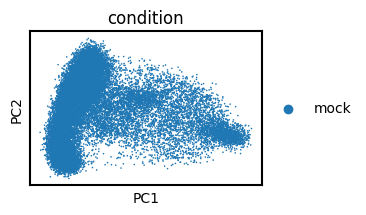

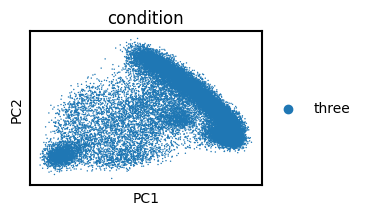

In [ ]:
sc.pl.pca(mock_adata,
          color=["condition"],
          cmap="coolwarm")

sc.pl.pca(day_three,
          color=["condition"],
          cmap="coolwarm")

In [ ]:
#mock
sc.pp.neighbors(mock_adata)
sc.tl.umap(mock_adata)

#day 1
sc.pp.neighbors(day_one)
sc.tl.umap(day_one)

#day 2
sc.pp.neighbors(day_two)
sc.tl.umap(day_two)

#day 3
sc.pp.neighbors(day_three)
sc.tl.umap(day_three)

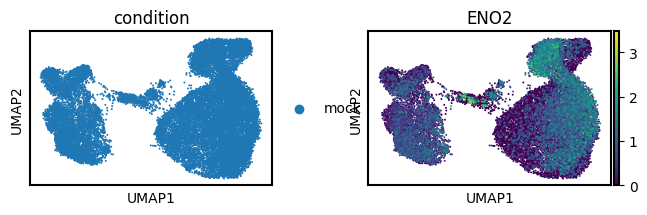

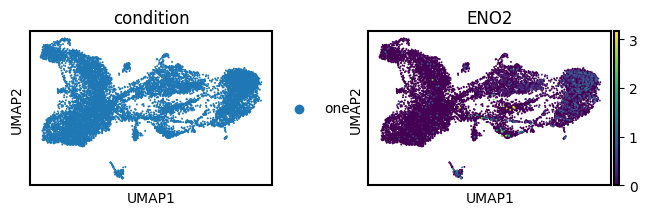

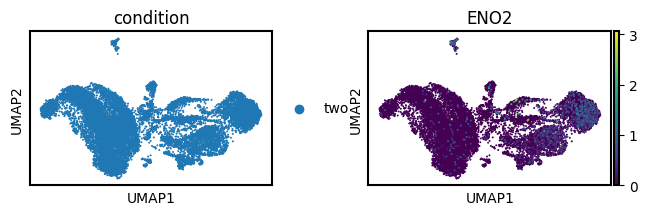

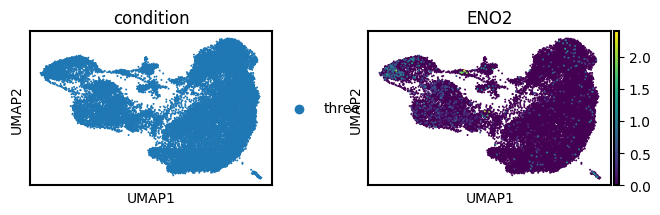

In [ ]:
sc.pl.umap(
    mock_adata,
   color=["condition", 'ENO2'],
    size=8,
)

sc.pl.umap(
    day_one,
   color=["condition", 'ENO2'],
    size=8,
)

sc.pl.umap(
    day_two,
   color=["condition", 'ENO2'],
    size=8,
)

sc.pl.umap(
    day_three,
   color=["condition", 'ENO2'],
    size=8,
)

In [ ]:
#mock
sc.tl.leiden(mock_adata, flavor="igraph", n_iterations=10, key_added="leiden_res_", resolution=0.25 )
#day 1
sc.tl.leiden(day_one, flavor="igraph", n_iterations=10, key_added="leiden_res_", resolution=0.1 )
#day 2
sc.tl.leiden(day_two, flavor="igraph", n_iterations=10, key_added="leiden_res_", resolution=0.25 )
#day 3
sc.tl.leiden(day_three, flavor="igraph", n_iterations=10, key_added="leiden_res_", resolution=0.25 )

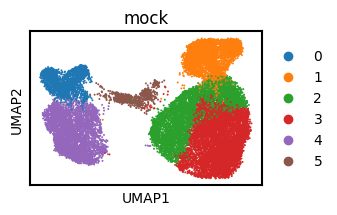

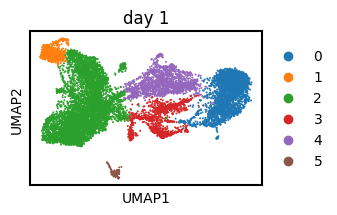

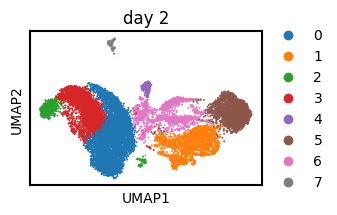

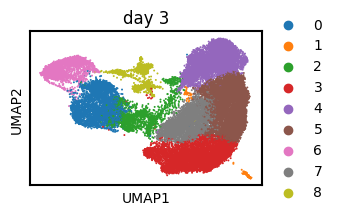

In [ ]:
sc.pl.umap(
    mock_adata,
    color=["leiden_res_"],
    size=8,
    title= 'mock'
)

sc.pl.umap(
    day_one,
    color=["leiden_res_"],
    size=8,
    title= 'day 1'
)

sc.pl.umap(
    day_two,
    color=["leiden_res_"],
    size=8,
    title= 'day 2'
)

sc.pl.umap(
    day_three,
    color=["leiden_res_"],
    size=8,
    title= 'day 3'
)

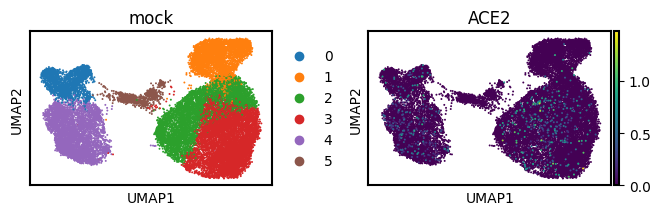

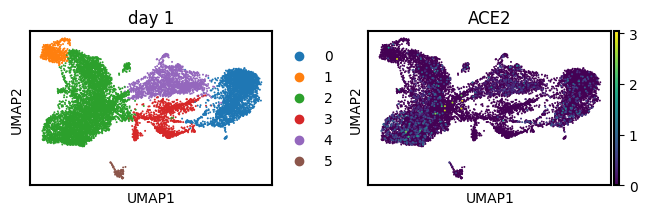

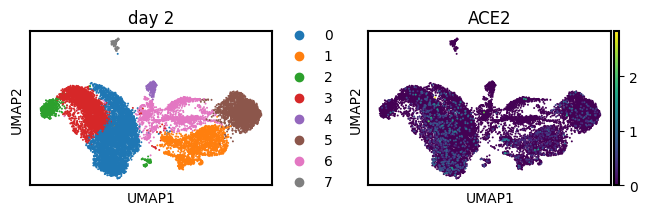

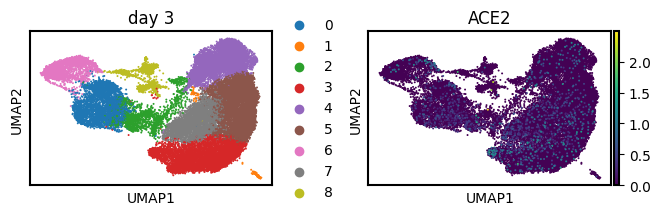

In [ ]:
sc.pl.umap(
    mock_adata,
    color=['leiden_res_', 'ACE2'],
    size=8,
    title= 'mock'
)

sc.pl.umap(
    day_one,
    color=['leiden_res_', 'ACE2'],
    size=8,
    title= 'day 1'
)

sc.pl.umap(
    day_two,
    color=['leiden_res_', 'ACE2'],
    size=8,
    title= 'day 2'
)

sc.pl.umap(
    day_three,
    color=['leiden_res_', 'ACE2'],
    size=8,
    title= 'day 3'
)

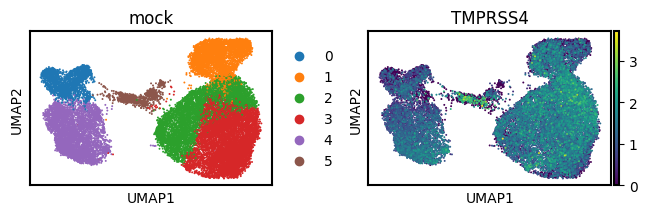

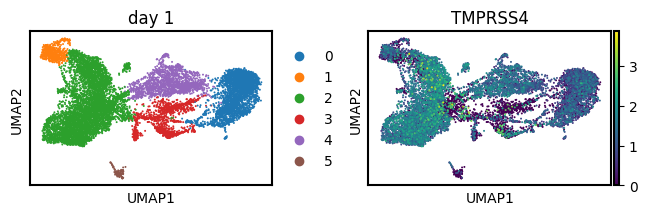

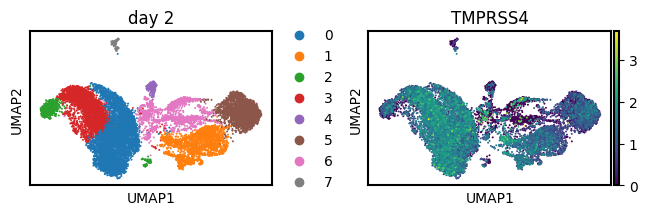

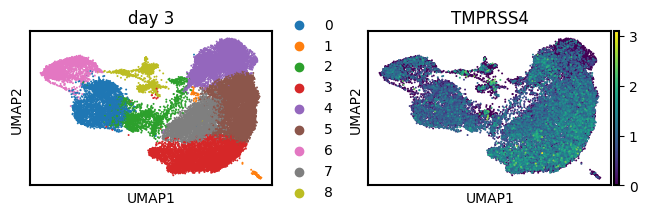

In [ ]:
sc.pl.umap(
    mock_adata,
    color=['leiden_res_', 'TMPRSS4'],
    size=8,
    title= 'mock'
)

sc.pl.umap(
    day_one,
    color=['leiden_res_', 'TMPRSS4'],
    size=8,
    title= 'day 1'
)

sc.pl.umap(
    day_two,
    color=['leiden_res_', 'TMPRSS4'],
    size=8,
    title= 'day 2'
)

sc.pl.umap(
    day_three,
    color=['leiden_res_', 'TMPRSS4'],
    size=8,
    title= 'day 3'
)

**Cell type annotation**


In [ ]:
!pip install decoupler
import decoupler as dc

In [ ]:
# Query Omnipath and get PanglaoDB
markers = dc.op.resource(name="PanglaoDB", organism="human")

In [ ]:
markers.shape


(8211, 13)

In [ ]:
markers.head()


,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
,,,,,,,,,,,,,
0,A1CF,False,Hepatocytes,Endoderm,True,0.189189,0.004437,True,0.175000,0.000257,9606,Liver,0.002
1,A2APA5,False,Germ cells,Mesoderm,False,0.000000,0.000000,True,0.432927,0.000000,10090,Reproductive,0.004
2,A2M,True,Bergmann glia,Ectoderm,True,0.000000,0.062343,True,0.333333,0.001604,9606,Brain,0.012
3,A3FIN4,False,Mast cells,Mesoderm,False,0.000000,0.000000,True,0.184211,0.000708,10090,Immune system,0.001
4,A4GALT,True,Mast cells,Mesoderm,True,0.000000,0.014133,True,0.000000,0.003023,9606,Immune system,0.005


In [ ]:
markers['organ'].unique()


array(['Liver', 'Reproductive', 'Brain', 'Immune system', 'Zygote',
       'Kidney', 'Blood', 'Lungs', 'Bone', 'GI tract', nan, 'Vasculature',
       'Pancreas', 'Heart', 'Mammary gland', 'Olfactory system',
       'Connective tissue', 'Epithelium', 'Skeletal muscle', 'Skin',
       'Embryo', 'Smooth muscle', 'Eye', 'Adrenal glands', 'Thyroid',
       'Placenta', 'Thymus', 'Parathyroid glands', 'Oral cavity',
       'Urinary bladder'], dtype=object)

In [ ]:
markers = markers[markers["organ"] == 'Lungs']


In [ ]:
markers.shape


(196, 13)

In [ ]:
# Query Omnipath and get PanglaoDB
#markers = dc.op.resource(name="PanglaoDB", organism="human")

# Keep canonical cell type markers alone
#markers = markers[markers["canonical_marker"]]

# Remove duplicated entries
markers = markers[~markers.duplicated(["cell_type", "genesymbol"])]

#Format because dc only accepts cell_type and genesymbol

markers = markers.rename(columns={"cell_type": "source", "genesymbol": "target"})
markers = markers[["source", "target"]]


markers.head()

,source,target
,,
18,Pulmonary alveolar type II cells,ABCA3
31,Pulmonary alveolar type II cells,ABCD3
172,Pulmonary alveolar type II cells,ADGRF5
186,Airway epithelial cells,ADH7
222,Pulmonary alveolar type I cells,AGER


In [ ]:
import gc # Garbage Collector için

# 1. İşlem
dc.mt.ulm(data=mock_adata, net=markers, tmin=3)
# İşlem bittikten sonra mock_adata'yı silin
del mock_adata
gc.collect() # Belleği hemen boşalt

# 2. İşlem
dc.mt.ulm(data=day_one, net=markers, tmin=3)
del day_one
gc.collect()

# 3. İşlem
dc.mt.ulm(data=day_two, net=markers, tmin=3)
del day_two
gc.collect()

# 4. İşlem
dc.mt.ulm(data=day_three, net=markers, tmin=3)
del day_three
gc.collect()

In [ ]:
#dc.mt.ulm(data=mock_adata,
          net=markers,
          tmin = 3)

#dc.mt.ulm(data=day_one,
          net=markers,
          tmin = 3)#

#dc.mt.ulm(data=day_two,
          net=markers,
          tmin = 3)

#dc.mt.ulm(data=day_three,
          net=markers,
          tmin = 3)#

In [ ]:
score_mock = dc.pp.get_obsm(mock_adata, key="score_ulm")

score_1 = dc.pp.get_obsm(day_one, key="score_ulm")

score_2 = dc.pp.get_obsm(day_two, key="score_ulm")

score_3 = dc.pp.get_obsm(day_three, key="score_ulm")

In [ ]:
#rank genes
## mock
mock_adata_gene_rank = dc.tl.rankby_group(score_mock, groupby="leiden_res_", reference="rest", method="t-test_overestim_var")
mock_adata_gene_rank = mock_adata_gene_rank[mock_adata_gene_rank["stat"] > 0]
mock_adata_gene_rank.head(5)

## day 1
one_adata_gene_rank = dc.tl.rankby_group(score_1, groupby="leiden_res_", reference="rest", method="t-test_overestim_var")
one_adata_gene_rank = one_adata_gene_rank[one_adata_gene_rank["stat"] > 0]
one_adata_gene_rank.head(5)

## day 2
two_adata_gene_rank = dc.tl.rankby_group(score_2, groupby="leiden_res_", reference="rest", method="t-test_overestim_var")
two_adata_gene_rank = two_adata_gene_rank[two_adata_gene_rank["stat"] > 0]
two_adata_gene_rank.head(5)

## day 3
three_adata_gene_rank = dc.tl.rankby_group(score_3, groupby="leiden_res_", reference="rest", method="t-test_overestim_var")
three_adata_gene_rank = three_adata_gene_rank[three_adata_gene_rank["stat"] > 0]
three_adata_gene_rank.head(5)

*pre-clustering*


In [ ]:
!gzip /content/stage_3project/2dpi/matrix.mtx

In [ ]:
# Run once if not already installed
!pip install --quiet scanpy scikit-misc python-igraph leidenalg


In [ ]:
import scanpy as sc
import os

# adjust if your folders are elsewhere
base = '/content/stage_3project'
mock_adata = sc.read_10x_mtx(os.path.join(base,'mock/'))
day_one   = sc.read_10x_mtx(os.path.join(base,'1dpi/'))
day_two   = sc.read_10x_mtx(os.path.join(base,'2dpi/'))
day_three = sc.read_10x_mtx(os.path.join(base,'3dpi/'))

mock_adata.obs['condition'] = 'mock'
day_one.obs['condition'] = 'one'
day_two.obs['condition'] = 'two'
day_three.obs['condition'] = 'three'

print("Loaded shapes:")
print("mock:", mock_adata)
print("1dpi:", day_one)
print("2dpi:", day_two)
print("3dpi:", day_three)


Loaded shapes:
mock: AnnData object with n_obs × n_vars = 22609 × 33539
    obs: 'condition'
    var: 'gene_ids', 'feature_types'
1dpi: AnnData object with n_obs × n_vars = 11834 × 33539
    obs: 'condition'
    var: 'gene_ids', 'feature_types'
2dpi: AnnData object with n_obs × n_vars = 14695 × 33539
    obs: 'condition'
    var: 'gene_ids', 'feature_types'
3dpi: AnnData object with n_obs × n_vars = 28530 × 33539
    obs: 'condition'
    var: 'gene_ids', 'feature_types'


In [ ]:
import scanpy as sc
adatas = [mock_adata, day_one, day_two, day_three]
for ad, name in zip(adatas, ['mock','one','two','three']):
    ad.obs['sample'] = name

# concatenate (anndata.concat recommended, but this follows your pipeline)
adata = adatas[0].concatenate(adatas[1:], batch_key='batch', batch_categories=['mock','one','two','three'], index_unique=None)

# make obs names unique to avoid index conflicts
adata.obs_names_make_unique()

# mark mitochondrial genes (assumes gene symbols like MT-)
adata.var['mt'] = adata.var_names.str.upper().str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

print("Concatenated:", adata)
print(adata.obs.groupby('sample')[['n_genes_by_counts','total_counts','pct_counts_mt']].median())


/tmp/ipython-input-4277749100.py:7: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adatas[0].concatenate(adatas[1:], batch_key='batch', batch_categories=['mock','one','two','three'], index_unique=None)
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1796: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1796: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Concatenated: AnnData object with n_obs × n_vars = 77668 × 33539
    obs: 'condition', 'sample', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
        n_genes_by_counts  total_counts  pct_counts_mt
sample                                                
mock               2233.0        6900.0       4.092023
one                3620.5       11998.0       7.059559
three              2129.0        5572.5       8.657486
two                3368.0       10857.0       7.127603


In [ ]:
# QC thresholds used in your pipeline (adjust if needed)
sc.pp.filter_cells(adata, min_counts=500)
sc.pp.filter_genes(adata, min_cells=30)
adata = adata[adata.obs.pct_counts_mt < 20, :]
adata = adata[adata.obs.n_genes_by_counts < 8000, :]
adata = adata[adata.obs.n_genes_by_counts > 300, :]

print("After filtering:", adata)


After filtering: View of AnnData object with n_obs × n_vars = 75313 × 20131
    obs: 'condition', 'sample', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'


/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.12/dist-packages/legacy_api_wrap/__init__.py:88: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)
/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/tmp/ipython-input-3785442614.py:16: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added='leiden_r0.6', resolution=0.6)


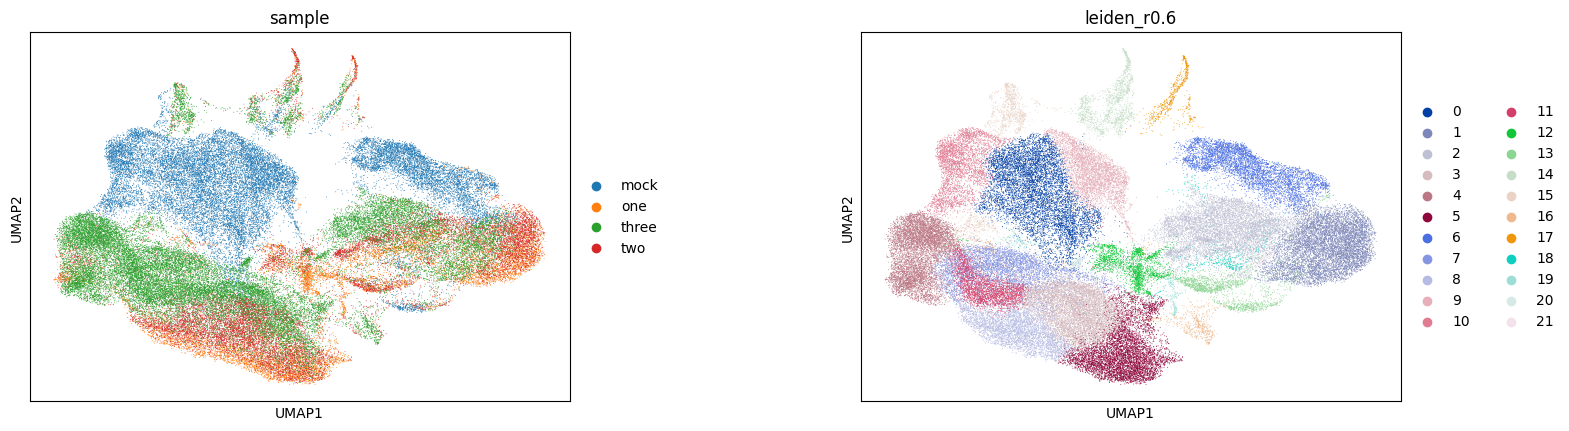

Saved merged_h5ad


In [ ]:
import scanpy as sc
import numpy as np

# normalize + log
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# HVG selection (seurat_v3; requires scikit-misc)
sc.pp.highly_variable_genes(adata, n_top_genes=3000, subset=True, flavor='seurat_v3')

# scale + PCA + neighbors + UMAP + leiden
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added='leiden_r0.6', resolution=0.6)

# quick plots (optional)
sc.pl.umap(adata, color=['sample','leiden_r0.6'], wspace=0.4, show=True)

# save merged adata for mapping later
adata.write('/content/merged_sarscov2_postQC.h5ad')
print("Saved merged_h5ad")


In [ ]:
!pip install --quiet decoupler


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.9/120.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.9 MB/s eta 0:00:00


In [ ]:
import decoupler as dc
import pandas as pd
import os

# 1) PanglaoDB'den çek
markers = dc.op.resource(name="PanglaoDB", organism="human")

# (Opsiyonel) yalnızca canonical markerları kullanmak istersen:
# markers = markers[markers["canonical_marker"] == True]

# 2) Çoğaltılmış satırları kaldır
markers = markers[~markers.duplicated(["cell_type","genesymbol"])]

# 3) dc.mt.ulm ile uyumlu format: source=cell_type, target=genesymbol
markers = markers.rename(columns={"cell_type":"source","genesymbol":"target"})
markers = markers[["source","target"]]

# 4) Göster / kaydet
print("Markers shape:", markers.shape)
display(markers.head(10))

# Save a copy (optional) so you can reuse across sessions
os.makedirs('/content/markers_out', exist_ok=True)
markers.to_csv('/content/markers_out/markers_panglao.csv', index=False)
print("Saved markers to /content/markers_out/markers_panglao.csv")


Markers shape: (8190, 2)


,source,target
,,
0,Hepatocytes,A1CF
1,Germ cells,A2APA5
2,Bergmann glia,A2M
3,Mast cells,A3FIN4
4,Mast cells,A4GALT
5,Embryonic stem cells,A7KBS4
6,Interneurons,AAK1
7,Neurons,AAK1
8,Pinealocytes,AANAT


Saved markers to /content/markers_out/markers_panglao.csv


In [ ]:
# basit kontrol
print("markers defined:", 'markers' in globals())
print("rows:", markers.shape[0])
print("unique cell types:", markers['source'].nunique())
# örnek birkaç cell_type göster
print(markers['source'].value_counts().head(10))


markers defined: True
rows: 8190
unique cell types: 178
source
Interneurons         222
Neurons              210
Endothelial cells    195
Fibroblasts          179
Germ cells           166
Mast cells           155
Hepatocytes          154
Macrophages          153
Enterocytes          151
Dendritic cells      137
Name: count, dtype: int64


In [ ]:
# PRE-CLUSTER ULM execution (memory friendly)
import scanpy as sc
import numpy as np
import gc
import pickle
import os

OUT_DIR = '/content/dc_results_by_cluster'
os.makedirs(OUT_DIR, exist_ok=True)

MAX_CELLS_PER_CLUSTER = 3000   # if cluster > this, subsample down to this
MIN_CELLS_TO_RUN = 50          # skip tiny clusters
RANDOM_STATE = 0

cluster_key = 'leiden_r0.6'   # your cluster labels
clusters = sorted(adata.obs[cluster_key].unique(), key=lambda x: int(x) if str(x).isdigit() else x)
print("Clusters to process:", clusters)

# Ensure markers variable exists in the environment.
# If markers is not defined, raise informative error:
try:
    markers
except NameError:
    raise NameError("Please define 'markers' variable in the notebook before running this cell (markers = ...)")

for cl in clusters:
    print("\n--- cluster:", cl, " ---")
    ad_cl = adata[adata.obs[cluster_key] == cl].copy()
    n_cells = ad_cl.n_obs
    print("cells:", n_cells)
    if n_cells < MIN_CELLS_TO_RUN:
        print("Skipping: too few cells.")
        continue

    # Subsample if cluster is large
    if n_cells > MAX_CELLS_PER_CLUSTER:
        print(f"Subsampling {n_cells} -> {MAX_CELLS_PER_CLUSTER}")
        sc.pp.subsample(ad_cl, n_obs=MAX_CELLS_PER_CLUSTER, random_state=RANDOM_STATE)

    # run heavy function (wrap in try/catch)
    try:
        print("Running dc.mt.ulm on cluster", cl)
        result = dc.mt.ulm(data=ad_cl, net=markers, tmin=3)
        # If dc.mt.ulm writes its own outputs, you may skip pickle saving
    except Exception as e:
        print("Error for cluster", cl, ":", e)
        # save error text
        with open(os.path.join(OUT_DIR, f'cluster_{cl}_error.txt'), 'w') as f:
            f.write(str(e))
        del ad_cl
        gc.collect()
        continue

    # save result to disk (adjust if function returns differently)
    outpath = os.path.join(OUT_DIR, f'cluster_{cl}_result.pkl')
    try:
        with open(outpath, 'wb') as fh:
            pickle.dump(result, fh, protocol=4)
        print("Saved:", outpath)
    except Exception as e:
        print("Could not pickle result (maybe function saved internally):", e)

    # cleanup
    del ad_cl, result
    gc.collect()


Clusters to process: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21']

--- cluster: 0  ---
cells: 7551
Subsampling 7551 -> 3000
Running dc.mt.ulm on cluster 0
Saved: /content/dc_results_by_cluster/cluster_0_result.pkl

--- cluster: 1  ---
cells: 7509
Subsampling 7509 -> 3000
Running dc.mt.ulm on cluster 1
Saved: /content/dc_results_by_cluster/cluster_1_result.pkl

--- cluster: 2  ---
cells: 7289
Subsampling 7289 -> 3000
Running dc.mt.ulm on cluster 2
Saved: /content/dc_results_by_cluster/cluster_2_result.pkl

--- cluster: 3  ---
cells: 7210
Subsampling 7210 -> 3000
Running dc.mt.ulm on cluster 3
Saved: /content/dc_results_by_cluster/cluster_3_result.pkl

--- cluster: 4  ---
cells: 6385
Subsampling 6385 -> 3000
Running dc.mt.ulm on cluster 4
Saved: /content/dc_results_by_cluster/cluster_4_result.pkl

--- cluster: 5  ---
cells: 6208
Subsampling 6208 -> 3000
Running dc.mt.ulm on cluster 5
Saved: /content/dc_results_

In [ ]:
import pickle, glob, os
pfiles = sorted(glob.glob('/content/dc_results_by_cluster/*.pkl'))
print("Found", len(pfiles), "pkl files. Example:", pfiles[:3])

# load first one and inspect
with open(pfiles[0], 'rb') as f:
    r = pickle.load(f)
print("Type:", type(r))
# try to show small preview depending on type
import pandas as pd
if isinstance(r, pd.DataFrame):
    display(r.head())
elif isinstance(r, dict):
    print("Keys:", list(r.keys())[:20])
    # try to show edges if present
    for k in ('edges','edge_list','edgeList'):
        if k in r:
            df = pd.DataFrame(r[k])
            display(df.head())
            break
elif isinstance(r, (list,tuple)):
    print("First 5 entries:", r[:5])
else:
    try:
        import igraph as ig
        if isinstance(r, ig.Graph):
            print("igraph with", len(r.vs), "nodes and", len(r.es), "edges")
    except Exception:
        print("Unknown object; repr:")
        print(repr(r)[:1000])


Found 22 pkl files. Example: ['/content/dc_results_by_cluster/cluster_0_result.pkl', '/content/dc_results_by_cluster/cluster_10_result.pkl', '/content/dc_results_by_cluster/cluster_11_result.pkl']
Type: <class 'NoneType'>


In [ ]:
!echo "---- files in /content/dc_results_by_cluster ----"
!ls -lh /content/dc_results_by_cluster | sed -n '1,400p'

!echo " "
!echo "---- top-level content ----"
!ls -lh /content | sed -n '1,200p'

!echo " "
!echo "---- recent files in /content (last 3600s) ----"
!find /content -maxdepth 3 -mmin -60 -ls | sed -n '1,200p'


---- files in /content/dc_results_by_cluster ----
total 88K
-rw-r--r-- 1 root root 4 Dec  7 16:59 cluster_0_result.pkl
-rw-r--r-- 1 root root 4 Dec  7 16:59 cluster_10_result.pkl
-rw-r--r-- 1 root root 4 Dec  7 16:59 cluster_11_result.pkl
-rw-r--r-- 1 root root 4 Dec  7 16:59 cluster_12_result.pkl
-rw-r--r-- 1 root root 4 Dec  7 16:59 cluster_13_result.pkl
-rw-r--r-- 1 root root 4 Dec  7 16:59 cluster_14_result.pkl
-rw-r--r-- 1 root root 4 Dec  7 16:59 cluster_15_result.pkl
-rw-r--r-- 1 root root 4 Dec  7 16:59 cluster_16_result.pkl
-rw-r--r-- 1 root root 4 Dec  7 16:59 cluster_17_result.pkl
-rw-r--r-- 1 root root 4 Dec  7 17:00 cluster_18_result.pkl
-rw-r--r-- 1 root root 4 Dec  7 17:00 cluster_19_result.pkl
-rw-r--r-- 1 root root 4 Dec  7 16:59 cluster_1_result.pkl
-rw-r--r-- 1 root root 4 Dec  7 17:00 cluster_20_result.pkl
-rw-r--r-- 1 root root 4 Dec  7 17:00 cluster_21_result.pkl
-rw-r--r-- 1 root root 4 Dec  7 16:59 cluster_2_result.pkl
-rw-r--r-- 1 root root 4 Dec  7 16:59 clust

In [ ]:
import inspect
import decoupler as dc

print("SIGNATURE:")
print(inspect.signature(dc.mt.ulm))
print("\n\nFIRST PART OF DOCSTRING:")
print((dc.mt.ulm.__doc__ or "")[:4000])   # uzun olabilir; ilk 4000 char'ı göster


SIGNATURE:
(data: anndata._core.anndata.AnnData | pandas.core.frame.DataFrame | tuple[numpy.ndarray, numpy.ndarray, numpy.ndarray], net: pandas.core.frame.DataFrame, tmin: int | float = 5, raw: bool = False, empty: bool = True, bsize: int | float = 250000, verbose: bool = False, **kwargs)


FIRST PART OF DOCSTRING:
Univariate Linear Model (ULM) :cite:`decoupler`.

This approach uses the molecular features from one observation as the population of samples
and it fits a linear model with a single covariate, which is the feature weights of a set :math:`F`.

.. math::

    y_i = \beta_0 + \beta_1 x_i + \varepsilon, \quad i = 1, 2, \ldots, n

Where:

- :math:`y_i` is the observed feature statistic (e.g. gene expression, :math:`log_{2}FC`, etc.) for feature :math:`i`
- :math:`x_i` is the weight of feature :math:`i` in feature set :math:`F`. For unweighted sets, membership in the set is indicated by 1, and non-membership by 0.
- :math:`\beta_0` is the intercept
- :math:`\beta_1` is the slope 

In [ ]:
import glob, time, pickle, os
import scanpy as sc

cl = '0'
ad_cl = adata[adata.obs['leiden_r0.6']==cl].copy()
if ad_cl.n_obs > 2000:
    sc.pp.subsample(ad_cl, n_obs=2000, random_state=0)

# snapshot before
before = set(glob.glob('/content/**/*', recursive=True))

# run (time it)
import time
t0 = time.time()
res = dc.mt.ulm(data=ad_cl, net=markers, tmin=3)
t1 = time.time()

# snapshot after
after = set(glob.glob('/content/**/*', recursive=True))
new = sorted(list(after - before))

print("dc.mt.ulm returned type:", type(res))
print("Time (s):", round(t1-t0,2))
print("Number of new files in /content:", len(new))
# list first 200 new files if any
for f in new[:200]:
    print(f)

# if res is not None, show a small repr
if res is not None:
    try:
        import pandas as pd
        if isinstance(res, pd.DataFrame):
            display(res.head())
        else:
            print("repr:", repr(res)[:1000])
    except Exception:
        print("repr:", repr(res)[:500])


dc.mt.ulm returned type: <class 'NoneType'>
Time (s): 0.46
Number of new files in /content: 0


In [ ]:
# çalıştır: hangi obs/obsm/var eklenmiş kontrolü
import pandas as pd

cl = '0'
ad_cl = adata[adata.obs['leiden_r0.6']==cl].copy()

print(">>> columns before:", ad_cl.obs.shape[1])
cols_before = set(ad_cl.obs.columns.tolist())

# run ulm (no subsampling here; safe small cluster already)
res = dc.mt.ulm(data=ad_cl, net=markers, tmin=3, verbose=True, tval=True)  # verbose ve tval ekledim
print("returned:", type(res))

cols_after = set(ad_cl.obs.columns.tolist())
new_cols = sorted(list(cols_after - cols_before))
print("New obs columns (if any):", new_cols[:50])

# check obsm and varm too
print("obsm keys:", list(ad_cl.obsm.keys())[:20])
print("varm keys:", list(ad_cl.varm.keys())[:20])

# if res is a dataframe-like, show small preview
try:
    import pandas as pd
    if isinstance(res, pd.DataFrame):
        display(res.head())
except Exception:
    pass


>>> columns before: 16


net['weight'] = 1


returned: <class 'NoneType'>
New obs columns (if any): []
obsm keys: ['X_pca', 'X_umap', 'score_ulm', 'padj_ulm']
varm keys: ['PCs']


In [ ]:
# inspect score_ulm / padj_ulm shape & marker sources mapping (works on ad_cl from last test)
import numpy as np

print("obsm keys:", list(ad_cl.obsm.keys()))
s = ad_cl.obsm['score_ulm']
p = ad_cl.obsm['padj_ulm']
print("score_ulm shape:", np.asarray(s).shape)
print("padj_ulm shape:", np.asarray(p).shape)

# candidate source names (unique sources in markers)
sources = markers['source'].unique().tolist()
print("n unique sources in markers:", len(sources))

# if number of columns equals number of sources, we can name columns by sources
if np.asarray(s).ndim == 2 and np.asarray(s).shape[1] == len(sources):
    print("Columns match sources: will use markers['source'] as column names.")
    print("First 20 sources:", sources[:20])
else:
    print("Columns do NOT match marker sources; show a preview of first row:")
    print(np.asarray(s)[0,:10])



obsm keys: ['X_pca', 'X_umap', 'score_ulm', 'padj_ulm']
score_ulm shape: (7551, 147)
padj_ulm shape: (7551, 147)
n unique sources in markers: 178
Columns do NOT match marker sources; show a preview of first row:
[-0.14307318 -0.71321298  0.13136805  0.91218833 -1.20637771 -0.07355152
 -0.44371446 -0.98549371 -0.47753386  0.09578175]


In [ ]:
# 1. determine filtered source list in original order (tmin must match what you used)
tmin = 3   # senin dc.mt.ulm çağrında kullandığın değer
# keep original order of first appearance
original_sources = list(markers['source'].drop_duplicates())
# counts per source
counts = markers['source'].value_counts()  # pandas Series
# select sources meeting tmin, preserving original order
filtered_sources = [s for s in original_sources if counts.get(s,0) >= tmin]

print("Original unique sources:", len(original_sources))
print("Sources with >= tmin targets:", len(filtered_sources))
print("First 20 filtered sources:", filtered_sources[:20])


Original unique sources: 178
Sources with >= tmin targets: 174
First 20 filtered sources: ['Hepatocytes', 'Germ cells', 'Bergmann glia', 'Mast cells', 'Embryonic stem cells', 'Interneurons', 'Neurons', 'Pinealocytes', 'Astrocytes', 'Sertoli cells', 'Cajal-Retzius cells', 'Purkinje neurons', 'Spermatozoa', 'Distal tubule cells', 'Platelets', 'Pulmonary alveolar type II cells', 'Hematopoietic stem cells', 'B cells naive', 'Plasma cells', 'Proximal tubule cells']


In [ ]:
# HÜCRE 2 — tüm clusterlar için isimlendirilmiş score/padj CSV üret
import numpy as np, pandas as pd, os, scanpy as sc, gc, time

OUT_DIR = '/content/dc_results_by_cluster_scores_named'
os.makedirs(OUT_DIR, exist_ok=True)

MAX_CELLS_PER_CLUSTER = 3000
clusters = sorted(adata.obs['leiden_r0.6'].unique(), key=lambda x: int(x) if str(x).isdigit() else x)

# filtered_sources computed earlier (sources with >= tmin targets)
# if not present, recompute quickly:
try:
    filtered_sources
except NameError:
    tmin = 3
    original_sources = list(markers['source'].drop_duplicates())
    counts = markers['source'].value_counts()
    filtered_sources = [s for s in original_sources if counts.get(s,0) >= tmin]

print("Will use", len(filtered_sources), "filtered sources for column names.")

for cl in clusters:
    print("Cluster", cl)
    ad_cl = adata[adata.obs['leiden_r0.6']==cl].copy()
    if ad_cl.n_obs == 0:
        print("  empty, skip")
        continue
    if ad_cl.n_obs > MAX_CELLS_PER_CLUSTER:
        sc.pp.subsample(ad_cl, n_obs=MAX_CELLS_PER_CLUSTER, random_state=0)
        print("  subsampled to", MAX_CELLS_PER_CLUSTER)
    t0 = time.time()
    _ = dc.mt.ulm(data=ad_cl, net=markers, tmin=3)
    t1 = time.time()
    print("  ran in", round(t1-t0,1), "s")
    score = np.asarray(ad_cl.obsm['score_ulm'])
    padj  = np.asarray(ad_cl.obsm['padj_ulm'])
    if score.ndim == 1:
        score = score.reshape(-1,1)
    if score.shape[1] == len(filtered_sources):
        cols = filtered_sources
    else:
        cols = [f"F{i}" for i in range(score.shape[1])]
        print(f"  WARNING: column count {score.shape[1]} != filtered_sources {len(filtered_sources)}. Using F0.. names.")
    df_score = pd.DataFrame(score, index=ad_cl.obs_names, columns=cols)
    df_padj  = pd.DataFrame(padj,  index=ad_cl.obs_names, columns=cols)
    df_score.to_csv(os.path.join(OUT_DIR, f'cluster_{cl}_score_named.csv'))
    df_padj.to_csv(os.path.join(OUT_DIR, f'cluster_{cl}_padj_named.csv'))
    print("  saved:", df_score.shape)
    del ad_cl, score, padj, df_score, df_padj
    gc.collect()


Will use 174 filtered sources for column names.
Cluster 0
  subsampled to 3000
  ran in 1.8 s
  saved: (3000, 147)
Cluster 1
  subsampled to 3000
  ran in 2.1 s
  saved: (3000, 147)
Cluster 2
  subsampled to 3000
  ran in 1.1 s
  saved: (3000, 147)
Cluster 3
  subsampled to 3000
  ran in 1.4 s
  saved: (3000, 147)
Cluster 4
  subsampled to 3000
  ran in 0.6 s
  saved: (3000, 147)
Cluster 5
  subsampled to 3000
  ran in 0.6 s
  saved: (3000, 147)
Cluster 6
  subsampled to 3000
  ran in 0.6 s
  saved: (3000, 147)
Cluster 7
  subsampled to 3000
  ran in 0.9 s
  saved: (3000, 147)
Cluster 8
  subsampled to 3000
  ran in 0.6 s
  saved: (3000, 147)
Cluster 9
  subsampled to 3000
  ran in 0.6 s
  saved: (3000, 147)
Cluster 10
  subsampled to 3000
  ran in 0.6 s
  saved: (3000, 147)
Cluster 11
  ran in 0.8 s
  saved: (2974, 147)
Cluster 12
  ran in 0.6 s
  saved: (2087, 147)
Cluster 13
  ran in 0.4 s
  saved: (1861, 147)
Cluster 14
  ran in 0.3 s
  saved: (1593, 147)
Cluster 15
  ran in 0.3 s


In [ ]:
!ls -lh /content/dc_results_by_cluster_scores_named | sed -n '1,200p'


total 250M
-rw-r--r-- 1 root root 8.1M Dec  7 18:02 cluster_0_padj_named.csv
-rw-r--r-- 1 root root 8.4M Dec  7 18:02 cluster_0_score_named.csv
-rw-r--r-- 1 root root 8.1M Dec  7 18:03 cluster_10_padj_named.csv
-rw-r--r-- 1 root root 8.4M Dec  7 18:03 cluster_10_score_named.csv
-rw-r--r-- 1 root root 8.0M Dec  7 18:03 cluster_11_padj_named.csv
-rw-r--r-- 1 root root 8.3M Dec  7 18:03 cluster_11_score_named.csv
-rw-r--r-- 1 root root 5.6M Dec  7 18:03 cluster_12_padj_named.csv
-rw-r--r-- 1 root root 5.9M Dec  7 18:03 cluster_12_score_named.csv
-rw-r--r-- 1 root root 5.0M Dec  7 18:03 cluster_13_padj_named.csv
-rw-r--r-- 1 root root 5.3M Dec  7 18:03 cluster_13_score_named.csv
-rw-r--r-- 1 root root 4.4M Dec  7 18:03 cluster_14_padj_named.csv
-rw-r--r-- 1 root root 4.5M Dec  7 18:03 cluster_14_score_named.csv
-rw-r--r-- 1 root root 3.7M Dec  7 18:03 cluster_15_padj_named.csv
-rw-r--r-- 1 root root 3.9M Dec  7 18:03 cluster_15_score_named.csv
-rw-r--r-- 1 root root 2.0M Dec  7 18:03 clust

In [ ]:
import pandas as pd, glob
f = sorted(glob.glob('/content/dc_results_by_cluster_scores_named/*.csv'))[0]
print(f)
display(pd.read_csv(f, index_col=0).iloc[:6,:8])


/content/dc_results_by_cluster_scores_named/cluster_0_padj_named.csv


,F0,F1,F2,F3,F4,F5,F6,F7
CTCAAGAGTCCTGTTC-1,0.546791,0.761723,0.997411,0.351492,0.995488,0.997411,0.997411,0.997411
ACCATTTTCGCATGAT-1,0.978156,0.924872,0.924872,0.924872,0.924872,0.573843,0.924872,0.924872
ATATCCTCATGGTGGA-1,0.991088,0.991088,0.991088,0.105575,0.991088,0.934145,0.991088,0.991088
CTACTATCAATTCGTG-1,0.991279,0.835736,0.991279,0.991279,0.991279,0.991279,0.991279,0.991279
ATTCGTTCACGACGCT-1,0.988444,0.835903,0.988444,0.835903,0.103964,0.988444,0.900578,0.965848
AGGAAATTCACGGGCT-1,0.458514,0.898121,0.951122,0.886887,0.886887,0.194930,0.898121,0.898121


In [ ]:
# CLUSTER SCORE BİRLEŞTİRME (hocanın kullandığı mantık)

import pandas as pd
import glob
import os

SCORE_DIR = "/content/dc_results_by_cluster_scores_named"

score_files = sorted(glob.glob(os.path.join(SCORE_DIR, "*_score_named.csv")))

cluster_scores = []

for f in score_files:
    cl = f.split("_")[-3]   # cluster_X_score_named.csv → X
    print("Reading cluster", cl)
    df = pd.read_csv(f, index_col=0)

    # kolonların başına cluster id ekle
    df.columns = [f"{c}_cl{cl}" for c in df.columns]

    cluster_scores.append(df)

# tüm cluster skorlarını birleştir
merged_scores = pd.concat(cluster_scores, axis=1)

print("Final merged score matrix shape:", merged_scores.shape)

merged_scores.to_csv("/content/final_merged_ulm_scores.csv")
print("Saved -> /content/final_merged_ulm_scores.csv")


Reading cluster 0
Reading cluster 10
Reading cluster 11
Reading cluster 12
Reading cluster 13
Reading cluster 14
Reading cluster 15
Reading cluster 16
Reading cluster 17
Reading cluster 18
Reading cluster 19
Reading cluster 1
Reading cluster 20
Reading cluster 21
Reading cluster 2
Reading cluster 3
Reading cluster 4
Reading cluster 5
Reading cluster 6
Reading cluster 7
Reading cluster 8
Reading cluster 9
Final merged score matrix shape: (45560, 3234)
Saved -> /content/final_merged_ulm_scores.csv


In [ ]:
# 1) Cluster bazında ACE2 ortalaması (sadece 3 dpi hücreleri)
import numpy as np, pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

# değişken adların senin adata'da farklıysa uyarlayın (biz adata.obs['sample'] veya 'condition' kullandık)
# sample/condition sütununu kontrol et
print("sample unique:", adata.obs['sample'].unique(), "condition unique:", adata.obs['condition'].unique())

# use 'three' sample (3 dpi) — eğer senin sample isimleri farklı ise 'three' yerine uygun ismi koy
cells_3dpi = adata.obs_names[adata.obs['sample'] == 'three']
print("3 dpi cells:", len(cells_3dpi))

# pull ACE2 expression
gene = 'ACE2'
if gene not in adata.var_names:
    raise ValueError(f"{gene} not found in adata.var_names")
expr_all = adata[:, gene].X
# densify if sparse
try:
    expr_all = np.asarray(expr_all.todense()).ravel()
except AttributeError:
    expr_all = np.asarray(expr_all).ravel()

# subset to 3dpi
expr_3 = pd.Series(expr_all, index=adata.obs_names).reindex(cells_3dpi).fillna(0)

# cluster labels
cluster_key = 'leiden_r0.6'
clusters = adata.obs.loc[cells_3dpi, cluster_key].unique().tolist()

# compute cluster means
cluster_means = adata.obs.loc[cells_3dpi].groupby(cluster_key).apply(lambda df: expr_3.reindex(df.index).mean())
cluster_means = cluster_means.sort_values(ascending=False)
print("Cluster means (3 dpi) for ACE2:")
print(cluster_means)

# plot barplot (top 10)
topk = cluster_means.head(10)
plt.figure(figsize=(8,4))
topk.plot.bar()
plt.ylabel('Mean ACE2 expression (log1p-normalized)')
plt.title('Top 10 clusters by ACE2 mean expression (3 dpi)')
plt.show()

# UMAP colored by ACE2 for 3dpi cells (overlay)
adata.obs['ACE2_expr'] = pd.Series(expr_all, index=adata.obs_names)
sc.pl.umap(adata, color=['ACE2_expr', cluster_key], size=20, wspace=0.4)


sample unique: ['mock', 'one', 'two', 'three']
Categories (4, object): ['mock', 'one', 'three', 'two'] condition unique: ['mock', 'one', 'two', 'three']
Categories (4, object): ['mock', 'one', 'three', 'two']
3 dpi cells: 28046


ValueError: ACE2 not found in adata.var_names

In [ ]:
print("var columns:", adata.var.columns)
print("\nFirst 5 var rows:")
display(adata.var.head())

print("\nACE2 in gene_ids?:", "ACE2" in adata.var['gene_ids'].values if "gene_ids" in adata.var.columns else "gene_ids not in var")
print("ACE2 in index?:", "ACE2" in adata.var_names)


var columns: Index(['gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts',
       'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts',
       'log1p_total_counts', 'n_cells', 'highly_variable',
       'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean',
       'std'],
      dtype='object')

First 5 var rows:


,gene_ids,feature_types,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm,mean,std
HES4,ENSG00000188290,Gene Expression,False,39705,1.268309,0.819034,48.878560,98507.0,11.497893,39705,True,2501.0,0.566822,0.423733,1.109259,0.566822,0.650948
ISG15,ENSG00000187608,Gene Expression,False,29578,2.164534,1.152006,61.917392,168115.0,12.032410,29578,True,91.0,0.533603,0.809215,2.219921,0.533603,0.899564
TTLL10,ENSG00000162571,Gene Expression,False,13350,0.324175,0.280789,82.811454,25178.0,10.133765,13350,True,1621.0,0.140453,0.128332,1.176586,0.140453,0.358235
C1QTNF12,ENSG00000184163,Gene Expression,False,4043,0.060192,0.058450,94.794510,4675.0,8.450198,4043,True,1416.0,0.043749,0.042533,1.201386,0.043749,0.206235
LINC01786,ENSG00000230415,Gene Expression,False,45,0.000579,0.000579,99.942061,45.0,3.828641,45,True,537.0,0.000381,0.000444,1.422602,0.000381,0.021076



ACE2 in gene_ids?: False
ACE2 in index?: False


In [ ]:
ace2_id = "ENSG00000130234"
print("ACE2 ID in var_names:", ace2_id in adata.var_names)


ACE2 ID in var_names: False


In [ ]:
# show examples of var names and var columns
print("var columns:", adata.var.columns.tolist())
print("First 50 var_names (head):")
print(list(adata.var_names[:50]))
# show a few var rows for inspection
display(adata.var.head(5))


var columns: ['gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std']
First 50 var_names (head):
['HES4', 'ISG15', 'TTLL10', 'C1QTNF12', 'LINC01786', 'TAS1R3', 'CALML6', 'CFAP74', 'HES5', 'AC242022.1', 'MEGF6', 'AL513320.1', 'TP73', 'AL034417.3', 'ERRFI1', 'AL096855.1', 'CA6', 'SLC2A5', 'AL031291.1', 'AL031731.1', 'DRAXIN', 'NPPA', 'C1orf158', 'PDPN', 'FHAD1', 'AL031283.2', 'SRARP', 'CLCNKA', 'CLCNKB', 'CROCC', 'BX284668.6', 'AL590644.3', 'ALDH4A1', 'AKR7A3', 'RNF186', 'UBXN10', 'CAMK2N1', 'CDA', 'SH2D5', 'AL031281.2', 'WNT4', 'ID3', 'MYOM3', 'GRHL3', 'AL033528.2', 'STMN1', 'SH3BGRL3', 'UBXN11', 'CD52', 'SFN']


,gene_ids,feature_types,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm,mean,std
HES4,ENSG00000188290,Gene Expression,False,39705,1.268309,0.819034,48.878560,98507.0,11.497893,39705,True,2501.0,0.566822,0.423733,1.109259,0.566822,0.650948
ISG15,ENSG00000187608,Gene Expression,False,29578,2.164534,1.152006,61.917392,168115.0,12.032410,29578,True,91.0,0.533603,0.809215,2.219921,0.533603,0.899564
TTLL10,ENSG00000162571,Gene Expression,False,13350,0.324175,0.280789,82.811454,25178.0,10.133765,13350,True,1621.0,0.140453,0.128332,1.176586,0.140453,0.358235
C1QTNF12,ENSG00000184163,Gene Expression,False,4043,0.060192,0.058450,94.794510,4675.0,8.450198,4043,True,1416.0,0.043749,0.042533,1.201386,0.043749,0.206235
LINC01786,ENSG00000230415,Gene Expression,False,45,0.000579,0.000579,99.942061,45.0,3.828641,45,True,537.0,0.000381,0.000444,1.422602,0.000381,0.021076


In [ ]:
# çalıştır
for g in ['ACE2','ENO2']:
    in_varnames = g in adata.var_names
    in_gene_ids = any(adata.var['gene_ids'].astype(str).str.contains(g, case=False, na=False))
    print(f"{g}: in var_names? {in_varnames} ; appears in gene_ids column? {in_gene_ids}")
# ayrıca ENSG id ile kontrol (ACE2 ENSG00000130234, ENO2 ENSG00000172270)
for ens in ['ENSG00000130234','ENSG00000172270']:
    hits = adata.var['gene_ids'].astype(str).str.contains(ens, na=False)
    print(ens, "found in gene_ids?", hits.any())


ACE2: in var_names? False ; appears in gene_ids column? False
ENO2: in var_names? True ; appears in gene_ids column? False
ENSG00000130234 found in gene_ids? False
ENSG00000172270 found in gene_ids? False


In [ ]:
import numpy as np, pandas as pd

gene = 'ENO2'
cluster_key = 'leiden_r0.6'

def get_expr_by_var(gname):
    X = adata[:, gname].X
    try:
        return np.asarray(X.todense()).ravel()
    except:
        return np.asarray(X).ravel()

# 3 dpi hücreleri al
cells_3dpi = adata.obs_names[adata.obs['sample'] == 'three']
print("3 dpi cells:", len(cells_3dpi))

# ENO2 expression series
expr = pd.Series(get_expr_by_var(gene), index=adata.obs_names)

# 3 dpi kesiti
expr_3dpi = expr.loc[cells_3dpi]

# cluster ortalamaları
cluster_means = expr_3dpi.groupby(adata.obs.loc[cells_3dpi, cluster_key]).mean()
cluster_means = cluster_means.sort_values(ascending=False)

print("\nENO2 mean expression per cluster (3 dpi):")
print(cluster_means)


3 dpi cells: 28046

ENO2 mean expression per cluster (3 dpi):
leiden_r0.6
17   -0.157365
18   -0.201181
1    -0.204553
2    -0.285736
21   -0.328775
13   -0.332959
16   -0.348470
12   -0.354842
15   -0.363152
20   -0.372234
14   -0.373927
11   -0.385317
4    -0.387368
7    -0.387471
5    -0.390591
3    -0.390663
8    -0.393291
0    -0.402886
10   -0.402886
9    -0.402886
6    -0.402886
19   -0.402886
dtype: float64


/tmp/ipython-input-3796515913.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_means = expr_3dpi.groupby(adata.obs.loc[cells_3dpi, cluster_key]).mean()


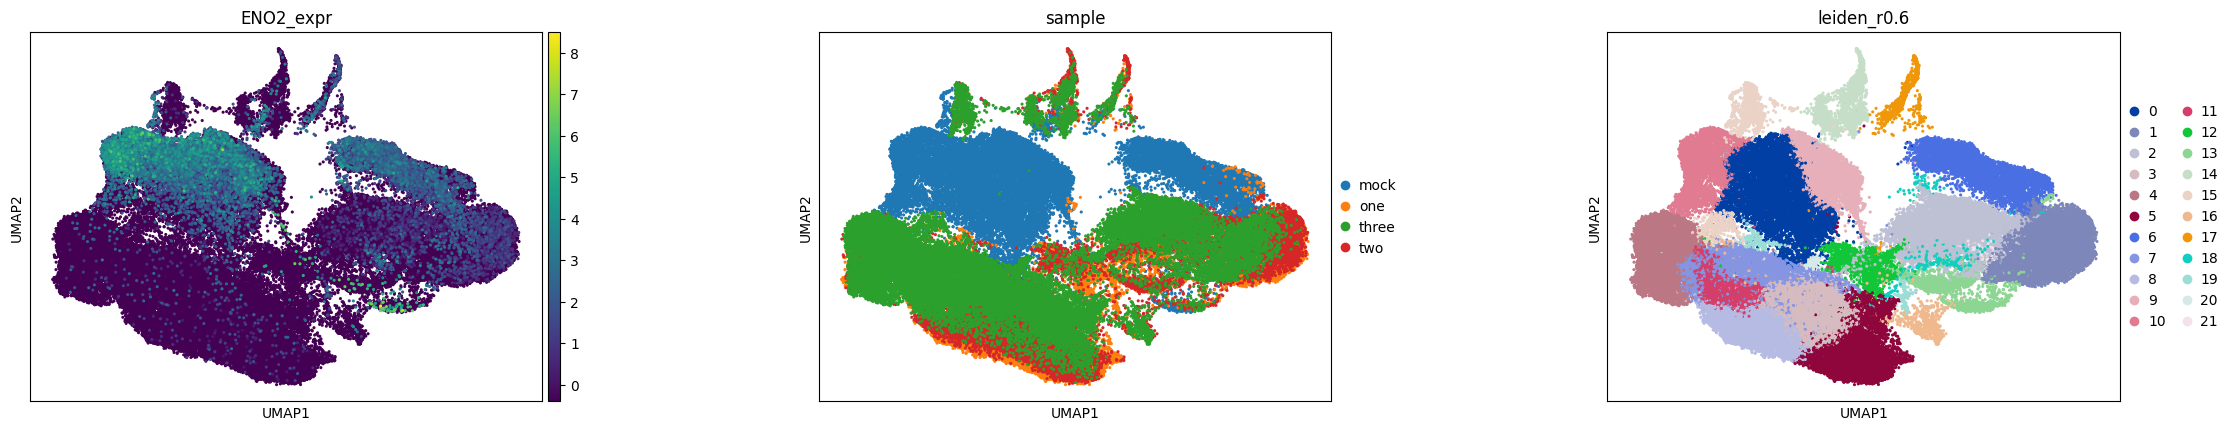

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# adata zaten yüklü; ENO2 var_names'te olduğundan emin olduk
adata.obs['ENO2_expr'] = pd.Series(adata[:, 'ENO2'].X.todense().A1 if hasattr(adata[:, 'ENO2'].X, "todense") else adata[:, 'ENO2'].X.flatten(), index=adata.obs_names)

# UMAP renkli göster (tüm hücre)
import scanpy as sc
sc.pl.umap(adata, color=['ENO2_expr','sample','leiden_r0.6'], wspace=0.4, size=20)


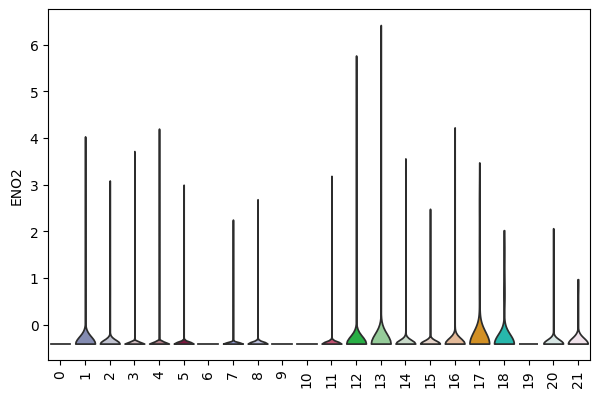

In [ ]:
# Violin by cluster (only 3 dpi cells or all — göster bakalım)
cells_3dpi = adata.obs_names[adata.obs['sample']=='three']
sc.pl.violin(adata[cells_3dpi], keys=['ENO2'], groupby='leiden_r0.6', rotation=90, size=1, stripplot=False)


In [ ]:
# compute rank genes if not yet computed (this may take a bit)
import scanpy as sc
if 'rank_genes_groups' not in adata.uns:
    sc.tl.rank_genes_groups(adata, groupby='leiden_r0.6', method='t-test_overestim_var', n_genes=50)

# show top 20 markers for cluster 17
df17 = sc.get.rank_genes_groups_df(adata, group='17')
display(df17.head(20))


/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:484: 

,names,scores,logfoldchanges,pvals,pvals_adj
0,TFF3,67.414886,NaN,0.000000e+00,0.000000e+00
1,SEC11C,66.733070,NaN,0.000000e+00,0.000000e+00
2,CALCA,64.639000,NaN,4.525543e-289,3.394157e-286
3,AZGP1,64.631561,NaN,1.179399e-303,1.179399e-300
4,SCG2,56.651066,NaN,1.643964e-259,9.863783e-257
5,ASCL1,55.224907,NaN,3.023876e-249,1.511938e-246
6,CPE,50.639374,NaN,1.044212e-243,4.475195e-241
7,RAB3B,47.667313,NaN,1.016901e-216,3.389669e-214
8,SCG3,45.327587,NaN,1.284213e-204,3.502400e-202
9,PCSK1N,43.967636,NaN,5.232198e-211,1.569659e-208


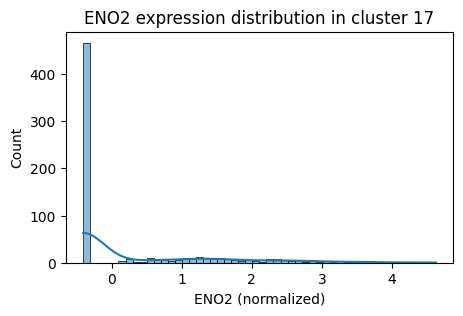

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
cells17 = adata.obs_names[adata.obs['leiden_r0.6']=='17']
vals = adata[cells17, 'ENO2'].X
try:
    vals = np.asarray(vals.todense()).ravel()
except:
    vals = np.asarray(vals).ravel()
plt.figure(figsize=(5,3))
sns.histplot(vals, bins=50, kde=True)
plt.title('ENO2 expression distribution in cluster 17')
plt.xlabel('ENO2 (normalized)')
plt.show()


In [ ]:
from scipy import stats
cells17 = adata.obs_names[adata.obs['leiden_r0.6']=='17']
others = adata.obs_names[adata.obs['leiden_r0.6']!='17']
v17 = pd.Series(adata[cells17, 'ENO2'].X.flatten(), index=cells17)
voth= pd.Series(adata[others, 'ENO2'].X.flatten(), index=others)
t, p = stats.ttest_ind(v17, voth, nan_policy='omit', equal_var=False)
print("t-stat:", t, "p-value:", p)


t-stat: 4.84924541400286 p-value: 1.5452403162794965e-06
